In [1]:
import pandas as pd
import nltk
import pickle

import glob
import pytextrank
from collections import Counter
from operator import itemgetter 
import string
from os import path
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import corpora,models
from gensim.models import LdaModel, LsiModel

# spacy for lemmatization
import spacy
from spacy.lang.en import English

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Widen the dataframe to show the long cells
pd.set_option('display.max_colwidth', 200)

In [61]:
df=pd.read_csv('noDup_data.csv')

In [62]:
d=df.content.to_list()

In [4]:
from nltk.corpus import stopwords
stop_words= stopwords.words('english')

In [5]:
data_words=[]
for sentence in d:
    word=gensim.utils.simple_preprocess(sentence, deacc=True)
    stop=[]
    for i in word:
        if i not in stop_words:
            stop.append(i)
    data_words.append(stop)

In [6]:
len(data_words)

842

### Bigram /Trigram

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(stop_words=stop_words, ngram_range=(2,3))
ngrams = c_vec.fit_transform(data['content'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

In [9]:
df_ngram.head(10)

,frequency,bigram/trigram
0,578,virginia beach
1,349,hampton roads
2,242,class region
3,150,oscar smith
4,138,great bridge
5,126,king fork
6,124,norfolk academy
7,120,ocean lakes
8,119,last year
9,114,high school


In [10]:
data_lemma=[]
nlp = spacy.load("en_core_web_sm")
for sent in data_words:
    doc = nlp(" ".join(sent)) 
    data_lemma.append([token.lemma_ for token in doc])

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemma)

# Create Corpus
texts = data_lemma

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [87]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True
)

In [88]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.120497 -0.219796       1        1  47.653801
3      0.018235 -0.368731       2        1  16.537603
5     -0.392005 -0.038767       3        1   8.963999
8     -0.193788  0.331950       4        1   8.561154
4      0.330502 -0.156408       5        1   7.403259
0      0.325805  0.137314       6        1   4.385581
2      0.129050  0.310120       7        1   2.530670
9     -0.233286 -0.207978       8        1   1.962502
1     -0.137627  0.121527       9        1   1.954858
6      0.032617  0.090769      10        1   0.046572, topic_info=             Term         Freq        Total Category  logprob  loglift
174           say  3517.000000  3517.000000  Default  30.0000  30.0000
204      virginia  1314.000000  1314.000000  Default  29.0000  29.0000
1736         game   764.000000   764.000000  Default  28.0000  28.0000
1490       police   342.000000   342.000000  Default  27.0000  27.0000
241      business   292.000000   292.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
4501  cheerleader     0.005686     2.309887  Topic10  -9.8266   1.6650
4497     anecdote     0.005686     2.474368  Topic10  -9.8267   1.5962
4507      jubilee     0.005686     2.478427  Topic10  -9.8267   1.5946
3923     krasnoff     0.005686    10.039883  Topic10  -9.8267   0.1956
4499      beloved     0.005686     2.927179  Topic10  -9.8267   1.4281

[598 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
953       3  0.993459  academy
1693      2  0.985911      acc
1544      1  0.657930   accord
1544      6  0.232023   accord
1544      9  0.108066   accord
...     ...       ...      ...
220       1  0.859546     year
220       2  0.069894     year
220       3  0.013384     year
220       4  0.011897     year
220       5  0.044613     year

[911 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 6, 9, 5, 1, 3, 10, 2, 7])

### LDA Mallet

In [47]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME']=r'C:\Users\yueyu\mallet-2.0.8'
mallet_path =r'C:\Users\yueyu\mallet-2.0.8\bin\mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [45]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [48]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemma, start=2, limit=30, step=6)

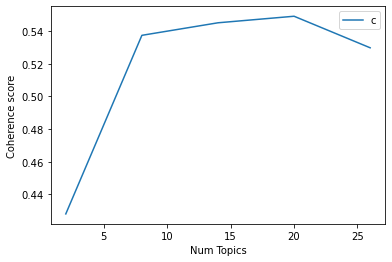

In [49]:
# Show graph
limit=30; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [52]:
pyLDAvis.enable_notebook()
optimal_model=model_list[3]
optmodel_20 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis_20 = pyLDAvis.gensim.prepare(optmodel_20, corpus, id2word, mds='mmds')
vis_20

C:\Users\yueyu\anaconda3_new\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\yueyu\anaconda3_new\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\yueyu\anaconda3_new\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17    -0.248132 -0.153973       1        1  7.720928
7     -0.484338 -0.053444       2        1  6.476191
10    -0.010303 -0.142508       3        1  6.101743
12    -0.159454 -0.335720       4        1  6.016586
16     0.127941  0.467169       5        1  5.594086
2     -0.168399  0.156748       6        1  5.489851
9     -0.421361  0.239422       7        1  4.954137
8     -0.356344 -0.316142       8        1  4.948574
0     -0.017497 -0.481018       9        1  4.874221
14     0.324523 -0.338557      10        1  4.829697
15     0.138945 -0.408083      11        1  4.809208
19     0.204176  0.316422      12        1  4.675450
18    -0.327272  0.033995      13        1  4.619254
3      0.154410  0.098005      14        1  4.519489
4     -0.264391  0.377707      15        1  4.448523
13    -0.056388  0.384690      16        1  4.436866
5      0.256602 -0.155689      17        1  4.347505
1      0.489347 -0.075234      18        1  4.139435
11     0.420580  0.093516      19        1  3.617243
6      0.397357  0.292694      20        1  3.381015, topic_info=          Term         Freq        Total Category  logprob  loglift
1284       run   929.000000   929.000000  Default  30.0000  30.0000
204   virginia  1573.000000  1573.000000  Default  29.0000  29.0000
1408    school   684.000000   684.000000  Default  28.0000  28.0000
1736      game   893.000000   893.000000  Default  27.0000  27.0000
1313     beach   791.000000   791.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
145     office    51.352984   374.052509  Topic20  -5.0032   1.4013
649       john    41.798941   148.028903  Topic20  -5.2090   2.1225
416        amp    42.993196   215.182898  Topic20  -5.1808   1.7765
290      group    44.187452   339.666671  Topic20  -5.1534   1.3475
1799  saturday    41.798941   317.758403  Topic20  -5.2090   1.3586

[1890 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
222        2  0.796580      -PRON-
222       11  0.202306      -PRON-
10538     19  0.826058  abbreviate
9655      14  0.840403         abd
9830      14  1.008483    abdullah
...      ...       ...         ...
220       17  0.075402        year
220       19  0.043823        year
1837       2  1.002238      yellow
6115      12  0.990560       youth
11820     20  0.837342        zeus

[2999 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 8, 11, 13, 17, 3, 10, 9, 1, 15, 16, 20, 19, 4, 5, 14, 6, 2, 12, 7])

### Dominant Topics for each Article

In [64]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=d):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=d)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,15.0,0.4241,"year, play, story, book, show, kid, man, day, night, live","In the 1960s, spaghetti Westerns were box office smashes thanks to Italian directors like Sergio Leone, who could bring outlaws, saloons and gunfights to life on the big screen cheaply by making m..."
1,1,15.0,0.2793,"year, play, story, book, show, kid, man, day, night, live","Even five years after his death, Hanns Loewenbach's message remains true: Bigotry thrives not only because of hate, but because others see it and do nothing. Loewenbach, a local Holocaust survivo..."
2,2,15.0,0.4831,"year, play, story, book, show, kid, man, day, night, live","That blip of a generation known as X, born roughly between 1964 and 1982 ,including yours truly , is accustomed to being overlooked. That's always been our chief gripe, but it's also been a blessi..."
3,3,11.0,0.4228,"state, odu, team, texas, dominion, bowl, conference, league, north, round","today's highlights ON THE AIR College football Kent State at Western Michigan, 7 p.m., CBSSN Toledo at Ohio, 7 p.m., ESPN2 Eastern Michigan at Central Michigan, 8 p.m., ESPNU Golf Blue ..."
4,4,16.0,0.6901,"region, class, norfolk, academy, ocean, hampton, team, tournament, cox, colonial","Boys volleyball All-Region Multiclass 1-4 First team Nathan McGhee ,Heritage , George Giles ,Heritage , Tommy Speelman ,Great Bridge , Miking Johnson ,Heritage , Elijah Morris ,Heritage , ..."
5,5,16.0,0.7567,"region, class, norfolk, academy, ocean, hampton, team, tournament, cox, colonial","Field hockey All-Southeastern District First team Forwards: Peyton Tollaksen ,Great Bridge , Gabe Lechner ,Hickory , Ashlyn Rogers ,Nansemond River , Chloe Underwood ,Great Bridge , Faith ..."
6,6,12.0,0.4880,"virginia, city, year, election, state, candidate, district, voter, vote, northam","THE OPPORTUNITY for citizens to vote for their favorite candidates is often taken for granted in the United States, but not in many other parts of the world. The result is that a majority of eligi..."
7,7,8.0,0.0880,"plan, cost, tax, health, year, make, lead, change, pay, bill","I can't wait for Wednesday, when TV ads will go back to being about the wonder drugs that can prolong my life if the side effects don't kill me first. Andy Virga Virginia Beach"
8,8,13.0,0.2627,"art, show, work, year, sunday, norfolk, water, rise, king, sea","The consequences of sea-level rise and flooding from more powerful storms are being ignored by city leaders, residents and the Navy. Norfolk and the rest of Hampton Roads are experiencing the high..."
9,9,18.0,0.3582,"school, student, high, virginia, city, university, college, chesapeake, community, percent",The process of changing school attendance zones is both emotional and politically challenging. The Pilot's recent stories about the Chesapeake School Board rezoning decision clearly demonstrate th...


### Topic distribution across articles

In [103]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
df_dominant_topics=df_dominant_topics.sort_values(by=['Num_Documents'],ascending=False).reset_index(drop=True)
# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,3.0,"tech, week, game, rank, miami, season, team, average, back, duke",113,0.1342
1,7.0,"good, people, work, make, day, time, lot, thing, home, -PRON-",79,0.0938
2,15.0,"year, play, story, book, show, kid, man, day, night, live",71,0.0843
3,5.0,"navy, military, shipyard, year, accord, portsmouth, naval, ship, uss, norfolk",58,0.0689
4,19.0,"nov, virginia, event, business, beach, center, group, norfolk, information, store",57,0.0677
5,14.0,"beach, food, restaurant, cheese, grow, virginia, time, include, bay, open",51,0.0606
6,2.0,"trump, president, campaign, white, people, house, state, manafort, official, washington",48,0.0570
7,1.0,"run, kick, pass, class, county, fail, king, james, williams, smith",39,0.0463
8,4.0,"make, time, year, give, month, percent, week, ago, receive, part",38,0.0451
9,10.0,"company, business, service, year, program, employee, work, hampton, development, job",37,0.0439
